<table class="table table-bordered">
    <tr>
        <th style="text-align:center; vertical-align: middle; width:50%"><img src='https://www.np.edu.sg/images/default-source/default-album/img-logo.png'"></th>
        <th style="text-align:center;"><h1>Deep Learning in Natural Language Processing</h1><h2>Assignment (Problem 2) - Character Generator Model</h2><h3>AY2025/26 Semester</h3></th>
    </tr>
</table>

<h2>Name: Lim Ai Sim Elizabeth (3440680F)</h2>

### **Objective of this notebook**

1) Process a text document for use as training data for RNN-base model text
generation.

2) Building and training an RNN-based text generation model.

3) Test and evaluated the model.

### Preparation of notebook for use on Google Colab or AWS

In [ ]:

# FOR COLAB: Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# FOR COLAB, copy the dataset to the temp data directory for training

import shutil
import os

# Define the source and destination paths
source_dir = '/content/drive/MyDrive/Colab Notebooks/03-NLP/assignment/Harry_Potter_Book.txt'
destination_dir = '/content/sample_data/Harry_Potter_Book.txt'  # Specify the destination file path

# Create the destination directory if it doesn't exist
os.makedirs(os.path.dirname(destination_dir), exist_ok=True)

# Copy the dataset
shutil.copy(source_dir, destination_dir)

print(f"Dataset copied from {source_dir} to {destination_dir}")

# update data directory
data_dir = '/content/sample_data/Harry_Potter_Book.txt'

Dataset copied from /content/drive/MyDrive/Colab Notebooks/03-NLP/assignment/Harry_Potter_Book.txt to /content/sample_data/Harry_Potter_Book.txt


In [ ]:
# FOR AWS setup only

!ln -sf /opt/conda/nvvm/libdevice/libdevice.10.bc ./libdevice.10.bc

In [ ]:
# FOR AWS setup only

data_dir = '/Harry_Potter_Book.txt'

In [ ]:
# Import the Required Packages

from tensorflow import keras
print('keras: ', keras.__version__)

keras:  3.10.0


## Step 1 – Data Loading and Processing

### 1.1 Data Loading

In [ ]:
import numpy as np

# path = keras.utils.get_file(
#     'Harry_Potter_Book.txt', origin='/')
# text = open('/content/sample_data/Harry_Potter_Book.txt').read().lower()
text = open('/content/sample_data/Harry_Potter_Book.txt').read() # leave capital letters be. last model 6-3
print('Corpus length:', len(text))
print(type(text))

Corpus length: 676978
<class 'str'>


In [ ]:
# check the contents

print(text[:200])


/ 




OWL POST 

Harry Potter was a highly unusual boy in many ways. 
For one thing, he hated the summer holidays more 
than any other time of year. For another, he really 
wanted to do his homework 


In [ ]:
# get some statistics on the text

chars = sorted(list(set(text)))
print('Total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(indices_char)

Total chars: 86
{0: '\n', 1: ' ', 2: '!', 3: '"', 4: "'", 5: '(', 6: ')', 7: '*', 8: ',', 9: '-', 10: '.', 11: '/', 12: '0', 13: '1', 14: '2', 15: '3', 16: '4', 17: '5', 18: '6', 19: '7', 20: '8', 21: '9', 22: ':', 23: ';', 24: '?', 25: 'A', 26: 'B', 27: 'C', 28: 'D', 29: 'E', 30: 'F', 31: 'G', 32: 'H', 33: 'I', 34: 'J', 35: 'K', 36: 'L', 37: 'M', 38: 'N', 39: 'O', 40: 'P', 41: 'Q', 42: 'R', 43: 'S', 44: 'T', 45: 'U', 46: 'V', 47: 'W', 48: 'X', 49: 'Y', 50: 'Z', 51: '\\', 52: ']', 53: 'a', 54: 'b', 55: 'c', 56: 'd', 57: 'e', 58: 'f', 59: 'g', 60: 'h', 61: 'i', 62: 'j', 63: 'k', 64: 'l', 65: 'm', 66: 'n', 67: 'o', 68: 'p', 69: 'q', 70: 'r', 71: 's', 72: 't', 73: 'u', 74: 'v', 75: 'w', 76: 'x', 77: 'y', 78: 'z', 79: '|', 80: '~', 81: '—', 82: '‘', 83: '’', 84: '“', 85: '”'}


### 1.2 Data Loading and cleanup

### **Strict and flexible word removal functions**

In [ ]:
import re

def remove_phrases(text, phrases):
    # Create a more flexible pattern that accounts for spaces and punctuation within words
    # For example, "j.k. rowling" can be matched as "j.k. *rowling", "j k rowling", etc.
    pattern = r'\b(?:' + '|'.join(re.escape(p).replace(r'\ ', r'\s*').replace(r'\.', r'\.*') for p in phrases) + r')\b'
    cleaned_text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    # Remove extra spaces after substitution
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

import re

def remove_phrases_strict(text, phrases):
    pattern_string = '|'.join(re.escape(p) for p in phrases)
    pattern = re.compile(pattern_string, flags=re.IGNORECASE)
    cleaned_text = pattern.sub('', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

phrases_to_remove_strict = [
    "Harry Potter and the Prisoner of Azkaban",
    "J.K.",
    "Rowling",
    "Page"
]

phrases_to_remove_flex = [
    "J.K.",
    "Rowling",
    ]


text = open('/content/sample_data/Harry_Potter_Book.txt').read()
text = text.replace('\n', ' ').replace('\r', ' ')
text = re.sub(r'[^a-zA-Z\s.,!?;:\"\'`]', '', text)

text = remove_phrases_strict(text, phrases_to_remove_strict)
text = remove_phrases(text, phrases_to_remove_flex)

print('Corpus length after strict cleaning:', len(text))
print(text[:500])

Corpus length after strict cleaning: 607752
OWL POST Harry Potter was a highly unusual boy in many ways. For one thing, he hated the summer holidays more than any other time of year. For another, he really wanted to do his homework but was forced to do it in secret, in the dead of night. And he also happened to be a wizard. It was nearly midnight, and he was lying on his stomach in bed, the blankets drawn right over his head like a tent, a flashlight in one hand and a large leatherbound book A History of Magic by Bathilda Bagshot propped 


In [ ]:
# get some statistics on the text again

chars = sorted(list(set(text)))
print('Total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(indices_char)

Total chars: 61
{0: ' ', 1: '!', 2: '"', 3: "'", 4: ',', 5: '.', 6: ':', 7: ';', 8: '?', 9: 'A', 10: 'B', 11: 'C', 12: 'D', 13: 'E', 14: 'F', 15: 'G', 16: 'H', 17: 'I', 18: 'J', 19: 'K', 20: 'L', 21: 'M', 22: 'N', 23: 'O', 24: 'P', 25: 'Q', 26: 'R', 27: 'S', 28: 'T', 29: 'U', 30: 'V', 31: 'W', 32: 'X', 33: 'Y', 34: 'Z', 35: 'a', 36: 'b', 37: 'c', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'i', 44: 'j', 45: 'k', 46: 'l', 47: 'm', 48: 'n', 49: 'o', 50: 'p', 51: 'q', 52: 'r', 53: 's', 54: 't', 55: 'u', 56: 'v', 57: 'w', 58: 'x', 59: 'y', 60: 'z'}


### 1.3 Data encoding


This code prepares the text data for character-level text generation. It does the following:

- Sets parameters: maxlen defines the length of the input sequences (160 characters), and step determines how many characters to skip when creating the next sequence (3 characters).
- Creates lists: sentences will store the input sequences, and next_chars will store the target character that follows each sequence.
- Extracts sequences and targets: It iterates through the text, extracting sequences of maxlen characters and the character that immediately follows each sequence.
- Prints information: It prints the total number of sequences created and shows the first two extracted sequences and their corresponding next characters.
Identifies unique characters: It creates a sorted list (chars) of all the unique characters in the text.
- Creates character-to-index mapping: It builds a dictionary (char_indices) that maps each unique character to its numerical index in the chars list. This is useful for one-hot encoding later.

In [ ]:
# Length of extracted character sequences
maxlen = 160

# We sample a new sequence every `step` characters
step = 3

# This holds our extracted sequences
sentences = []

# This holds the targets (the follow-up characters)
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))
print('sentences[0]: ',sentences[0])
print('next_chars[0]: ',next_chars[0])
print('\n')
print('sentences[1]: ',sentences[1])
print('next_chars[1]: ',next_chars[1])

# List of unique characters in the corpus
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))
print(chars)

# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)

Number of sequences: 202531
sentences[0]:  OWL POST Harry Potter was a highly unusual boy in many ways. For one thing, he hated the summer holidays more than any other time of year. For another, he reall
next_chars[0]:  y


sentences[1]:   POST Harry Potter was a highly unusual boy in many ways. For one thing, he hated the summer holidays more than any other time of year. For another, he really w
next_chars[1]:  a
Unique characters: 61
[' ', '!', '"', "'", ',', '.', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


### Encoding the characters into arrays via One-Hot Encoding

In [ ]:
# Next, one-hot encode the characters into binary arrays.
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool_)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print('len(x): ',len(x))
print('x[0]: ',x[0])
print('len(y): ',len(y))
print('y[0]: ',y[0])

# print shape of x

print('Shape of x: ',x.shape)

Vectorization...
len(x):  202531
x[0]:  [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
len(y):  202531
y[0]:  [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False]
Shape of x:  (202531, 160, 61)


## Step 2 – Develop Character Generator Model

### 2.1 Loading the Libraries

In [ ]:
from tensorflow.keras import layers

# Libraries for training

# Import Libraries

from tensorflow import keras
print('keras: ', keras.__version__)

import numpy as np

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten,  Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers


# Simple RNN

from tensorflow.keras.layers import SimpleRNN


# LTSM

from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional


# GRU

from tensorflow.keras.layers import GRU



keras:  3.8.0


### 2.2. Functions for model training, and log generation

In [ ]:
# function for drawing plots

import matplotlib.pyplot as plt

def plot_loss(history_dict):
    """
    Plots the training and validation loss over epochs.

    Parameters:
    - history_dict: Dictionary with keys 'train_loss' and 'val_loss'.
    """
    epochs = range(1, len(history_dict['train_loss']) + 1)

    plt.figure(figsize=(5, 3))
    plt.plot(epochs, history_dict['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history_dict['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import sys
import random

# sampling function

def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-8) / temperature # take a log function and then divided by temperature
    exp_preds = np.exp(preds) # take a exp function
    preds = exp_preds / np.sum(exp_preds) # normalize to 1
    probas = np.random.multinomial(1, preds, 1) # roll a dice based on the probability distribution in preds
    return np.argmax(probas) #return to the selected "next character"


# function to generate text during training

def generate_text_during_training(model, text, maxlen, chars, char_indices, epoch, temperatures=[0.2, 0.5, 1.0], length=400, log_file=None):
    """
    Generate text from the model at the given epoch using a random seed.

    Parameters:
        model: trained keras model
        text: raw training text
        maxlen: length of input sequences
        chars: list of all unique characters
        char_indices: dict mapping char to index
        epoch: current epoch number (used in logging)
        temperatures: list of temperatures to try
        length: number of characters to generate
        log_file: optional file path to log the output
    """
    output_lines = []

    start_index = random.randint(0, len(text) - maxlen - 1)
    seed = text[start_index: start_index + maxlen]

    header = f'\n=== Epoch {epoch} | Seed: "{seed}" ===\n'
    print(header)
    output_lines.append(header)

    for temperature in temperatures:
        generated = seed
        line = f'\n-- Temperature {temperature} --\n{generated}'
        print(line, end='')
        output_lines.append(line)

        for _ in range(length):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated[-maxlen:]):
                sampled[0, t, char_indices[char]] = 1.0

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated += next_char
            sys.stdout.write(next_char)
            sys.stdout.flush()
            output_lines.append(next_char)

        print("\n")
        output_lines.append("\n")

    # Optional logging
    if log_file:
        with open(log_file, 'a', encoding='utf-8') as f:
            f.write(''.join(output_lines))


''' Example of use:

[1] No history tracking

for epoch in range(1, 61):
    print(f"\nEpoch {epoch}")
    model.fit(x, y, batch_size=128, epochs=1)

    if epoch == 1 or epoch % 10 == 0:
        generate_text_during_training(
            model=model,
            text=text,
            maxlen=maxlen,
            chars=chars,
            char_indices=char_indices,
            epoch=epoch,
            temperatures=[0.2, 0.5, 1.0],
            length=400,
            log_file="generated_text_log.txt"  # optional
        )


[2] With history tracking

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, 61):
    print(f"\nEpoch {epoch}")
    history = model.fit(x, y,
                        batch_size=128,
                        epochs=1,
                        validation_split=0.1,
                        verbose=1)

    # Save loss and accuracy after each epoch
    train_losses.append(history.history['loss'][0])
    val_losses.append(history.history['val_loss'][0])
    train_accuracies.append(history.history['accuracy'][0])
    val_accuracies.append(history.history['val_accuracy'][0])

    if epoch == 1 or epoch % 10 == 0:
        generate_text_during_training(
            model=model,
            text=text,
            maxlen=maxlen,
            chars=chars,
            char_indices=char_indices,
            epoch=epoch,
            log_file="generated_text_log.txt"
        )


'''


' Example of use:\n\n[1] No history tracking\n\nfor epoch in range(1, 61):\n    print(f"\nEpoch {epoch}")\n    model.fit(x, y, batch_size=128, epochs=1)\n\n    if epoch == 1 or epoch % 10 == 0:\n        generate_text_during_training(\n            model=model,\n            text=text,\n            maxlen=maxlen,\n            chars=chars,\n            char_indices=char_indices,\n            epoch=epoch,\n            temperatures=[0.2, 0.5, 1.0],\n            length=400,\n            log_file="generated_text_log.txt"  # optional\n        )\n\n\n[2] With history tracking\n\ntrain_losses = []\nval_losses = []\ntrain_accuracies = []\nval_accuracies = []\n\nfor epoch in range(1, 61):\n    print(f"\nEpoch {epoch}")\n    history = model.fit(x, y,\n                        batch_size=128,\n                        epochs=1,\n                        validation_split=0.1,\n                        verbose=1)\n\n    # Save loss and accuracy after each epoch\n    train_losses.append(history.history[\'lo

In [ ]:
# function for training with history tracking

def train_model_with_tracking(
    model,
    x, y,
    text, maxlen, chars, char_indices,
    epochs=60,
    batch_size=128,
    validation_split=0.1,
    generate_every=10,
    generate_func=None,
    log_file="generated_text_log.txt"
):
    """
    Train a character-level model with metrics tracking and optional text generation.

    Parameters:
        model: compiled Keras model
        x, y: training data
        text, maxlen, chars, char_indices: required for text generation
        epochs: number of training epochs
        batch_size: training batch size
        validation_split: fraction of training data used for validation
        generate_every: generate text every N epochs (or on epoch 1)
        generate_func: function to call for text generation (e.g., generate_text_during_training)
        log_file: path to save generated text samples
    Returns:
        history_dict: dictionary with training/validation loss and accuracy per epoch
    """
    history_dict = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(1, epochs + 1):
        print(f"\n Epoch {epoch}/{epochs}")

        history = model.fit(
            x, y,
            batch_size=batch_size,
            epochs=1,
            validation_split=validation_split,
            verbose=1
        )

        # Record metrics
        history_dict['train_loss'].append(history.history['loss'][0])
        history_dict['val_loss'].append(history.history['val_loss'][0])
        # history_dict['train_acc'].append(history.history['accuracy'][0])
        # history_dict['val_acc'].append(history.history['val_accuracy'][0])

        # Generate sample text periodically
        if epoch == 1 or (generate_every and epoch % generate_every == 0):
            if generate_func is not None:
                generate_func(
                    model=model,
                    text=text,
                    maxlen=maxlen,
                    chars=chars,
                    char_indices=char_indices,
                    epoch=epoch,
                    log_file=log_file
                )

    return history_dict



'''
  Example use:

  history = train_model_with_tracking(
    model=model,
    x=x,
    y=y,
    text=text,
    maxlen=maxlen,
    chars=chars,
    char_indices=char_indices,
    epochs=60,
    generate_func=generate_text_during_training,  # Optional
    log_file="generated_text_log.txt"
)

'''

'\n  Example use:\n\n  history = train_model_with_tracking(\n    model=model,\n    x=x,\n    y=y,\n    text=text,\n    maxlen=maxlen,\n    chars=chars,\n    char_indices=char_indices,\n    epochs=60,\n    generate_func=generate_text_during_training,  # Optional\n    log_file="generated_text_log.txt"\n)\n\n'

### 2.3. Function for viewing generated text logs

In [ ]:
import re

def view_generated_text_log(log_file, epoch_filter=None, temperature_filter=None):
    """
    Load and inspect generated text logs from a file.

    Parameters:
        log_file: path to the text log file (e.g., "generated_text_log.txt")
        epoch_filter: list or int of epoch(s) to display (optional)
        temperature_filter: list or float of temperature(s) to display (optional)

    Prints matching results to screen.
    """
    try:
        with open(log_file, 'r', encoding='utf-8') as f:
            content = f.read()
    except FileNotFoundError:
        print(f"File not found: {log_file}")
        return

    # Split content into blocks by epoch
    blocks = re.split(r"=== Epoch (\d+) \| Seed: ", content)

    # The first item in blocks is empty or a prefix; following items alternate: [epoch_num, seed_text + rest]
    for i in range(1, len(blocks), 2):
        epoch = int(blocks[i])
        body = blocks[i + 1]

        if epoch_filter is not None:
            if isinstance(epoch_filter, int) and epoch != epoch_filter:
                continue
            elif isinstance(epoch_filter, list) and epoch not in epoch_filter:
                continue

        print(f"\n\n🧪 Epoch {epoch}")
        seed_match = re.match(r'"(.*?)"', body)
        seed = seed_match.group(1) if seed_match else "Unknown seed"
        print(f"Seed: \"{seed}\"")

        # Find each temperature block
        temp_blocks = re.findall(r"-- Temperature ([\d.]+) --\n(.*?)(?=\n-- Temperature|\Z)", body, re.DOTALL)

        for temp_str, gen_text in temp_blocks:
            temperature = float(temp_str)
            if temperature_filter is not None:
                if isinstance(temperature_filter, float) and temperature != temperature_filter:
                    continue
                elif isinstance(temperature_filter, list) and temperature not in temperature_filter:
                    continue

            print(f"\n🌡️ Temperature: {temperature}")
            print(gen_text.strip())

### 2.4. Functions for evaluating generated text

In [ ]:
# Repetitiveness and diversity

import re
from collections import Counter

def evaluate_text_diversity(text):
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)  # Extract words
    unique_words = set(words)
    unique_chars = set(text)

    # Repetition: how often is a word repeated consecutively?
    repeated_sequences = sum(1 for i in range(1, len(words)) if words[i] == words[i - 1])

    diversity_metrics = {
        'total_chars': len(text),
        'unique_char_count': len(unique_chars),
        'unique_word_count': len(unique_words),
        'unique_word_ratio': len(unique_words) / len(words) if words else 0,
        'repetition_count': repeated_sequences,
        'repetition_rate': repeated_sequences / len(words) if words else 0
    }

    return diversity_metrics


# Dictionary words coverage

import nltk
nltk.download('words')
from nltk.corpus import words as nltk_words

english_vocab = set(w.lower() for w in nltk_words.words())

def evaluate_text_accuracy(text):
    text = text.lower()
    word_list = re.findall(r'\b\w+\b', text)

    known_words = [word for word in word_list if word in english_vocab]
    unknown_words = [word for word in word_list if word not in english_vocab]

    return {
        'total_words': len(word_list),
        'known_english_words': len(known_words),
        'unknown_words': len(unknown_words),
        'accuracy_ratio': len(known_words) / len(word_list) if word_list else 0
    }


def evaluate_generated_text(text):
    diversity = evaluate_text_diversity(text)
    accuracy = evaluate_text_accuracy(text)
    return {
        'diversity': diversity,
        'accuracy': accuracy
    }


'''
Example use:


generated_text = "Harry Harry went to to the the castle castle of Hogwarts. It it was amazing."
result = evaluate_generated_text(generated_text)

from pprint import pprint
pprint(result)

'''

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


'\nExample use:\n\n\ngenerated_text = "Harry Harry went to to the the castle castle of Hogwarts. It it was amazing."\nresult = evaluate_generated_text(generated_text)\n\nfrom pprint import pprint\npprint(result)\n\n'

### 2.5. Functions for generating text using trained model

In [ ]:
# text generation for evaluation of trained model

import numpy as np

def generate_text(model, seed_text, length, chars, char_indices, maxlen, temperature=1.0):
    generated = seed_text
    for _ in range(length):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated[-maxlen:]): # Use the last 'maxlen' characters as input
            if char in char_indices:
                x_pred[0, t, char_indices[char]] = 1.0

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated += next_char # Append the generated character

    return generated

### 2.6 Model design and training

### Model 1

In [ ]:
# build and compile model

model = Sequential()
model.add(keras.Input(shape=(maxlen, len(chars))))
model.add(layers.LSTM(256))
model.add(layers.Dense(len(chars), activation='softmax'))

print(model.summary())

optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       311,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 47)             │        12,079 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,375 (1.23 MB)

 Trainable params: 323,375 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# model training

history = train_model_with_tracking(
    model=model,
    x=x,
    y=y,
    text=text,
    maxlen=maxlen,
    chars=chars,
    char_indices=char_indices,
    epochs=60,
    generate_func=generate_text_during_training,  # Optional
    log_file="generated_text_log.txt")


 Epoch 1/60
1553/1553 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 2.4020 - val_loss: 1.6038

=== Epoch 1 | Seed: "llowed the crowd toward it, but had barely  glimpsed the enchanted ceiling, which was black and  clo" ===


-- Temperature 0.2 --
llowed the crowd toward it, but had barely  glimpsed the enchanted ceiling, which was black and  closs the fill  the was            page  199 harry potter and the prisoner of azkaban  j.k. rowling      hermione with        he was and  the grinned the fill down was  the firet of the for he was  the for the for he was started the fireted  the for the fireters and             page  199 harry potter and the prisoner of azkaban  j.k. rowling      he was  the firetred and         page  199 harry potte


-- Temperature 0.5 --
llowed the crowd toward it, but had barely  glimpsed the enchanted ceiling, which was black and  clow, harry to the wast the  professor   lupin and     he had the go the walk who said harry dargard, harry was looked at him.   the  

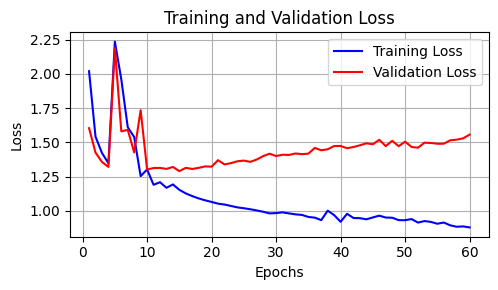

In [ ]:
plot_loss(history)

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/03-NLP/assignment/PROBLEM2/p2_model1.keras')

In [ ]:
# seed

import random

start_index = random.randint(0, len(text) - maxlen - 1) #randomly grab a piece of text from the original document
seed_text = text[start_index: start_index + maxlen] # what is used to input to the model for continuation

print("Seed text:\n", seed_text)

Seed text:
 voice.   beaky! said hagrid huskily.   page  449 harry potter and the prisoner of azkaban  j.k. rowl


In [ ]:
# generate text

generated_text = generate_text(
    model=model,
    seed_text=seed_text,
    length=400,
    chars=chars,
    char_indices=char_indices,
    maxlen=maxlen,
    temperature=0.5  # Adjust for creativity: lower = conservative, higher = creative
)

print("Generated text:\n", generated_text)

Generated text:
 rry was in a cleaky enough to harry, strode as  though he  was still looking around the  gryffindor 


In [ ]:
evaluate_generated_text(generated_text)

{'diversity': {'total_chars': 100,
  'unique_char_count': 20,
  'unique_word_count': 17,
  'unique_word_ratio': 0.9444444444444444,
  'repetition_count': 0,
  'repetition_rate': 0.0},
 'accuracy': {'total_words': 18,
  'known_english_words': 15,
  'unknown_words': 3,
  'accuracy_ratio': 0.8333333333333334}}

### Model 2

- add a dropout

In [ ]:
# build and compile model

model = Sequential()
model.add(keras.Input(shape=(maxlen, len(chars))))
model.add(layers.LSTM(256))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(chars), activation='softmax'))

print(model.summary())

optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 256)            │       311,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 47)             │        12,079 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,375 (1.23 MB)

 Trainable params: 323,375 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# model training

history = train_model_with_tracking(
    model=model,
    x=x,
    y=y,
    text=text,
    maxlen=maxlen,
    chars=chars,
    char_indices=char_indices,
    epochs=60,
    generate_func=generate_text_during_training,  # Optional
    log_file="generated_text_log.txt")


 Epoch 1/60
1553/1553 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 2.4998 - val_loss: 1.6078

=== Epoch 1 | Seed: "s for very long. he  seems aware, himself, that his time is short. he  positively fled when i offere" ===


-- Temperature 0.2 --
s for very long. he  seems aware, himself, that his time is short. he  positively fled when i offered the  the corting the read of the  said hermione   start                       hermione                       harry                           harry and the stired the the                             page  248 harry potter and the prisoner of azkaban  j.k. rowling                professor     professor     harry was  the cast                               harry was  the the done                   


-- Temperature 0.5 --
s for very long. he  seems aware, himself, that his time is short. he  positively fled when i offere hermione strow.   harry said crows ...   the readen the   hermione.   the cere for his hermione your in the  sece harry  said ron 

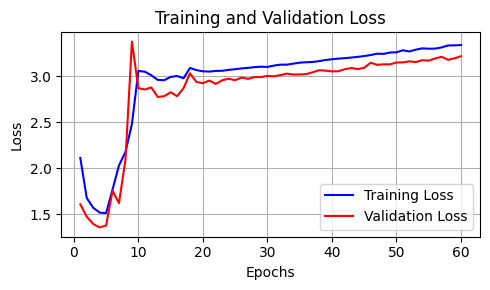

In [ ]:
plot_loss(history)

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/03-NLP/assignment/PROBLEM2/p2_model2.keras')

Maybe the dropout is too harsh.

### Model 3

In [ ]:
# build and compile model

model = Sequential()
model.add(keras.Input(shape=(maxlen, len(chars))))
model.add(layers.LSTM(256))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(chars), activation='softmax'))

print(model.summary())

optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 256)            │       299,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 35)             │         8,995 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,003 (1.17 MB)

 Trainable params: 308,003 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# model training

history = train_model_with_tracking(
    model=model,
    x=x,
    y=y,
    text=text,
    maxlen=maxlen,
    chars=chars,
    char_indices=char_indices,
    epochs=60,
    generate_func=generate_text_during_training,  # Optional
    log_file="generated_text_log.txt")


 Epoch 1/60
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - loss: 2.4465 - val_loss: 1.5671

=== Epoch 1 | Seed: " his face gleeful and his pale eyes glinting maliciously. shove off, malfoy, said ron, whose jaw was" ===


-- Temperature 0.2 --
 his face gleeful and his pale eyes glinting maliciously. shove off, malfoy, said ron, whose jaw was the sire of the professor lupin. but he said was the still fer the the thing to the was the firebort to the sere of the sire of the erched the tire the first of the was the stare and and the was the tire of the was the the the cound the was the traing to the started and harry potter andat the prisoner of azkaban j.k. and the was the sire of the said harry potter andat the prisoner of azkaban j.k.


-- Temperature 0.5 --
 his face gleeful and his pale eyes glinting maliciously. shove off, malfoy, said ron, whose jaw was secked and ron. stend not and at and harry potter andat the prisoner of azkaban j.k. but the grabbed but got the better and he sir

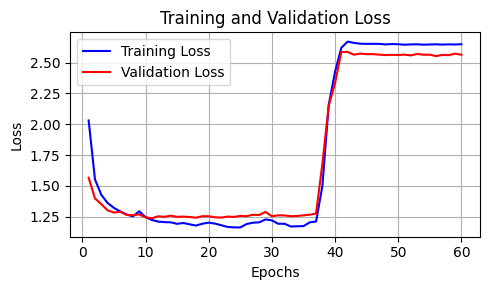

In [ ]:
plot_loss(history)

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/03-NLP/assignment/PROBLEM2/p2_model3.keras')

Comment: not too bad but an early stop is probably required.

### Model 4

- try stacked  RNN starting with smaller layer


In [ ]:
# build and compile model

model = Sequential()
model.add(keras.Input(shape=(maxlen, len(chars))))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(chars), activation='softmax'))

print(model.summary())

optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 100, 64)        │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 35)             │         2,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,899 (237.89 KB)

 Trainable params: 60,899 (237.89 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# model training

history = train_model_with_tracking(
    model=model,
    x=x,
    y=y,
    text=text,
    maxlen=maxlen,
    chars=chars,
    char_indices=char_indices,
    epochs=60,
    generate_func=generate_text_during_training,  # Optional
    log_file="generated_text_log.txt")


 Epoch 1/60
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 2.3308 - val_loss: 1.6222

=== Epoch 1 | Seed: " instead around rons outstretched arm. harry lunged forward, he seized a handful of the brutes hair," ===


-- Temperature 0.2 --
 instead around rons outstretched arm. harry lunged forward, he seized a handful of the brutes hair, said harry potter and the prisoner of azkaban j.k. the the cond the with and the start to the the were the start and the start to the stair to the wand to the stard to his the the the start of the wand to the the could the the with the the the was the start to the the looked the fing the the the were the stard the clost to the the with he was the with the stard the the with the with the tright th


-- Temperature 0.5 --
 instead around rons outstretched arm. harry lunged forward, he seized a handful of the brutes hair, lept ematter of the to was at at the wards and looking harry potter and the prisoner of azkaban j.k. the for the at it the sat. a 

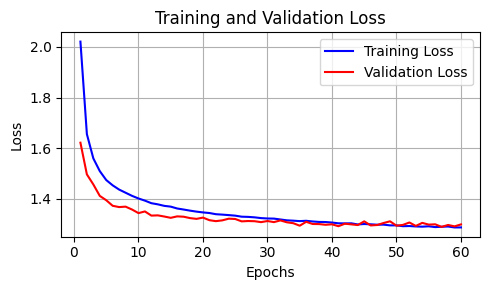

In [ ]:
# draw loss graph

plot_loss(history)

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/03-NLP/assignment/PROBLEM2/p2_model4.keras')

In [ ]:
# seed

import random

start_index = random.randint(0, len(text) - maxlen - 1) #randomly grab a piece of text from the original document
seed_text = text[start_index: start_index + maxlen] # what is used to input to the model for continuation

print("Seed text:\n", seed_text)

Seed text:
 y moved quickly behind a wide oak trunk and peered out from either side. hagrid had appeared in his 


In [ ]:
# generate text

generated_text = generate_text(
    model=model,
    seed_text=seed_text,
    length=400,
    chars=chars,
    char_indices=char_indices,
    maxlen=maxlen,
    temperature=0.5  # Adjust for creativity: lower = conservative, higher = creative
)

print("Generated text:\n", generated_text)

Generated text:
 y moved quickly behind a wide oak trunk and peered out from either side. hagrid had appeared in his acting to the cold couldnt keep the were your deep to leave the hand to the rest of the knight, not sight of the parly as the start the worst were didnt like fally for said the hagrid with the caught like the door of the caut of professor lupin told the backst the best full of madam rosmerta call to sit of your bag as the store seemed to look we was standed to keep why or a skinn. what took the wi


In [ ]:
evaluate_generated_text(generated_text)

{'diversity': {'total_chars': 500,
  'unique_char_count': 26,
  'unique_word_count': 71,
  'unique_word_ratio': 0.6893203883495146,
  'repetition_count': 0,
  'repetition_rate': 0.0},
 'accuracy': {'total_words': 103,
  'known_english_words': 90,
  'unknown_words': 13,
  'accuracy_ratio': 0.8737864077669902}}

This model looks good.

### Model 5

- try with a larger rnn model

In [ ]:
# build and compile model

model = Sequential()
model.add(keras.Input(shape=(maxlen, len(chars))))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.LSTM(128))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(chars), activation='softmax'))

print(model.summary())

optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 100, 128)       │        83,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,067 (859.64 KB)

 Trainable params: 220,067 (859.64 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# model training

history = train_model_with_tracking(
    model=model,
    x=x,
    y=y,
    text=text,
    maxlen=maxlen,
    chars=chars,
    char_indices=char_indices,
    epochs=60,
    generate_func=generate_text_during_training,  # Optional
    log_file="generated_text_log.txt")


 Epoch 1/60
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - loss: 2.6841 - val_loss: 1.7098

=== Epoch 1 | Seed: "is house, hed have met a fully grown werewolf but your father, whod heard what sirius had done, went" ===


-- Temperature 0.2 --
is house, hed have met a fully grown werewolf but your father, whod heard what sirius had done, went the tare the cast the said harry potter and the said harry potter and the mare the prisoner of the mare and the prisoner of the mare hermione said his the cast his the stain the said the said harry potter and the right the said harry potter and the said his said the right harry was said harry potter and the cas the cast the that the cas the prisoner of the said his the said the sure the tare the 


-- Temperature 0.5 --
is house, hed have met a fully grown werewolf but your father, whod heard what sirius had done, went a nid his greated his the said his the see hermione on the can bare. i so the ming the lained black the trust the cronk of azkaban

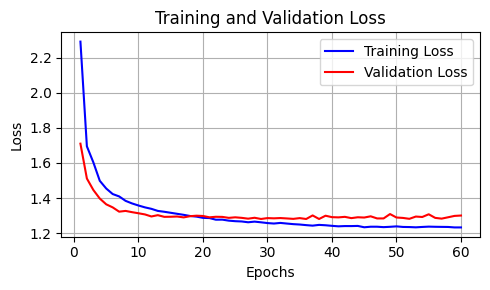

In [ ]:
# draw loss graph

plot_loss(history)

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/03-NLP/assignment/PROBLEM2/p2_model5.keras')

In [ ]:
# seed

import random

start_index = random.randint(0, len(text) - maxlen - 1) #randomly grab a piece of text from the original document
seed_text = text[start_index: start_index + maxlen] # what is used to input to the model for continuation

print("Seed text:\n", seed_text)

# generate text

generated_text = generate_text(
    model=model,
    seed_text=seed_text,
    length=400,
    chars=chars,
    char_indices=char_indices,
    maxlen=maxlen,
    temperature=0.5  # Adjust for creativity: lower = conservative, higher = creative
)

print("Generated text:\n", generated_text)

Seed text:
  really think so, severus? it looks to me as though it is merely a piece of parchment that insults a
Generated text:
  really think so, severus? it looks to me as though it is merely a piece of parchment that insults and began in the time of the rest of his dementors and couldnt see the parcsughting onto harry and harry had to see him. there was a swived the street. ron mounted to place. it was a stream of the firebolt was sfred and fight to minister, it was it was a secared in the still black boring to speak of the way him in the stunded that harry potter and the prisoner of azkaban j.k. harry this are he had 


In [ ]:
evaluate_generated_text(generated_text)

{'diversity': {'total_chars': 500,
  'unique_char_count': 27,
  'unique_word_count': 62,
  'unique_word_ratio': 0.6458333333333334,
  'repetition_count': 1,
  'repetition_rate': 0.010416666666666666},
 'accuracy': {'total_words': 96,
  'known_english_words': 84,
  'unknown_words': 12,
  'accuracy_ratio': 0.875}}

### Model 6

- 64
- adam optimiser


Note: at 128 for LSTM layers, the model exploded, so it was altered to 64.

In [ ]:
# build and compile model

model = Sequential()
model.add(keras.Input(shape=(maxlen, len(chars))))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(chars), activation='softmax'))

print(model.summary())

optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 100, 64)        │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 35)             │         2,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,899 (237.89 KB)

 Trainable params: 60,899 (237.89 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# model training

history = train_model_with_tracking(
    model=model,
    x=x,
    y=y,
    text=text,
    maxlen=maxlen,
    chars=chars,
    char_indices=char_indices,
    epochs=60,
    generate_func=generate_text_during_training,  # Optional
    log_file="generated_text_log.txt")


 Epoch 1/60
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 2.3604 - val_loss: 1.6644

=== Epoch 1 | Seed: "r lupin to try and see outside. im starving. i want to get to the feast. ... harry potter and the pr" ===


-- Temperature 0.2 --
r lupin to try and see outside. im starving. i want to get to the feast. ... harry potter and the prisoner of azkaban j.k. harry was better was at the was and the stapin the stapin the stares the seat stape the cant and the prisoner of azkaban j.k. harry stare harry potter and the prisoner of azkaban j.k. said in a seat hermione staring the harry stape the stains the prisoner of azkaban j.k. harry potter and the prisoner of azkaban j.k. harry potter and the stain the seath and the was and the pr


-- Temperature 0.5 --
r lupin to try and see outside. im starving. i want to get to the feast. ... harry potter and the prisoner of azkaban j.k. the passened the parting and the harry, said harry potter uld you leak harry potter and the for the seat the

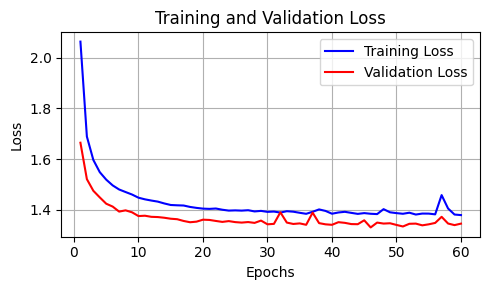

In [ ]:
# draw loss graph

plot_loss(history)

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/03-NLP/assignment/PROBLEM2/p2_model6.keras')

In [ ]:
# seed

import random

start_index = random.randint(0, len(text) - maxlen - 1) #randomly grab a piece of text from the original document
seed_text = text[start_index: start_index + maxlen] # what is used to input to the model for continuation

print("Seed text:\n", seed_text)

# generate text

generated_text = generate_text(
    model=model,
    seed_text=seed_text,
    length=400,
    chars=chars,
    char_indices=char_indices,
    maxlen=maxlen,
    temperature=0.5  # Adjust for creativity: lower = conservative, higher = creative
)

print("Generated text:\n", generated_text)

Seed text:
  what harry was staring at. youll start seeing death omens everywhere. its enough to frighten anyone
Generated text:
  what harry was staring at. youll start seeing death omens everywhere. its enough to frighten anyone were patting his hands and sink the floor the huge were shall. he wasnt loud went wont can steen and shrieked his hands had fine it was beat for him a to get of the emptipe harry lay like the gryffindor dursleys at the snoate to me to fell and he sight like behind the because feeling. and harry had been harry potter and the prisoner of azkaban j.k. the only a laying comples. and he could have the


In [ ]:
evaluate_generated_text(generated_text)

{'diversity': {'total_chars': 500,
  'unique_char_count': 26,
  'unique_word_count': 66,
  'unique_word_ratio': 0.6875,
  'repetition_count': 0,
  'repetition_rate': 0.0},
 'accuracy': {'total_words': 96,
  'known_english_words': 84,
  'unknown_words': 12,
  'accuracy_ratio': 0.875}}

### Model 7

In [ ]:
# build and compile model

model = Sequential()
model.add(keras.Input(shape=(maxlen, len(chars))))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(chars), activation='softmax'))

print(model.summary())

optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 160, 64)        │        32,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 160, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 61)             │         3,965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,269 (399.49 KB)

 Trainable params: 102,269 (399.49 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# model training

history = train_model_with_tracking(
    model=model,
    x=x,
    y=y,
    text=text,
    maxlen=maxlen,
    chars=chars,
    char_indices=char_indices,
    epochs=40,
    generate_func=generate_text_during_training,  # Optional
    log_file="generated_text_log.txt")


 Epoch 1/40
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 37s 23ms/step - loss: 2.6768 - val_loss: 1.9860

=== Epoch 1 | Seed: "I am, however, astounded that you didnt hand it in. Particularly after what happened the last time a student left information about the castle lying around. And" ===


-- Temperature 0.2 --
I am, however, astounded that you didnt hand it in. Particularly after what happened the last time a student left information about the castle lying around. And the the the the the the the the the said the dook the the the the the the said the singer the sout of the the said the said a statter the the the said the the said the the souking the souded a the the medered his the the the the the she the steaded the the the the the seaded the said the the the said a the the the said the the the the the the said the the the the the the the the the the shister t


-- Temperature 0.5 --
I am, however, astounded that you didnt hand it in. Particularly after what happened the last time a student le

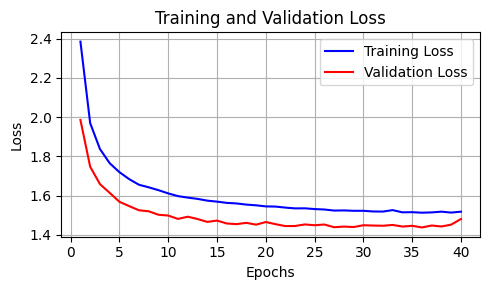

In [ ]:
# draw loss graph

plot_loss(history)

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/03-NLP/assignment/PROBLEM2/p2_model7.keras')

In [ ]:
# seed

import random

start_index = random.randint(0, len(text) - maxlen - 1) #randomly grab a piece of text from the original document
seed_text = text[start_index: start_index + maxlen] # what is used to input to the model for continuation

print("Seed text:\n", seed_text)

# generate text

generated_text = generate_text(
    model=model,
    seed_text=seed_text,
    length=400,
    chars=chars,
    char_indices=char_indices,
    maxlen=maxlen,
    temperature=0.5  # Adjust for creativity: lower = conservative, higher = creative
)

print("Generated text:\n", generated_text)

Seed text:
 ach end of the field; two Beaters, who were equipped with heavy bats to repel the Bludgers two heavy black balls that zoomed around trying to attack the players
Generated text:
 ach end of the field; two Beaters, who were equipped with heavy bats to repel the Bludgers two heavy black balls that zoomed around trying to attack the players to break to do the dolled to could see the they had been take a from more an the shoulder the only he got parents and Harry cant know and I see to the slus Black to Harry said short fell was the gany to have his tall of his books crandotts the was the classion was desk had go of the thought they could complet of the sacked to the classes to do the book the other more see the thing the sattide on 


In [ ]:
# evaluate generated text

evaluate_generated_text(generated_text)

{'diversity': {'total_chars': 560,
  'unique_char_count': 27,
  'unique_word_count': 70,
  'unique_word_ratio': 0.6140350877192983,
  'repetition_count': 0,
  'repetition_rate': 0.0},
 'accuracy': {'total_words': 114,
  'known_english_words': 99,
  'unknown_words': 15,
  'accuracy_ratio': 0.868421052631579}}

## Longer trainings

### Model 6-2

In [ ]:
# build and compile model

model = Sequential()
model.add(keras.Input(shape=(maxlen, len(chars))))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(chars), activation='softmax'))

print(model.summary())

optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 100, 64)        │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 35)             │         2,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,899 (237.89 KB)

 Trainable params: 60,899 (237.89 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# model training

history = train_model_with_tracking(
    model=model,
    x=x,
    y=y,
    text=text,
    maxlen=maxlen,
    chars=chars,
    char_indices=char_indices,
    epochs=100,
    generate_func=generate_text_during_training,  # Optional
    log_file="generated_text_log.txt")


 Epoch 1/100
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 2.4031 - val_loss: 1.7396

=== Epoch 1 | Seed: "o miserable, harry? he said quietly. you should be very proud of yourself after last night. . it did" ===


-- Temperature 0.2 --
o miserable, harry? he said quietly. you should be very proud of yourself after last night. . it did his the did the the stain the can the the corle to the forent the was harry could to the stain the was the tould the was was the stain the fill of the was was said the the the was the mard to the firent a taid the was was the was the tould the was the was said harry the the mant the could the stain a manted to the could the tould the the stain harry and the stain the was said the the could hermio


-- Temperature 0.5 --
o miserable, harry? he said quietly. you should be very proud of yourself after last night. . it didnt to fully, he to go the she was siding to harry was the mooned the round the him to the into had the crould and niming it the fe

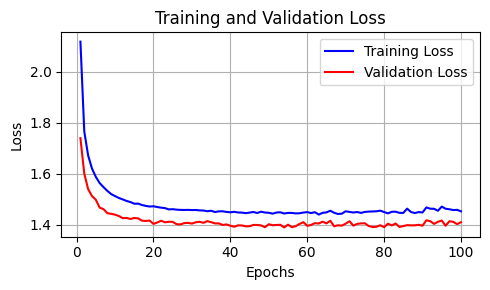

In [ ]:
# draw loss graph

plot_loss(history)

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/03-NLP/assignment/PROBLEM2/p2_model6_2.keras')

Comments: Signs of overfitting in repeating phrases used in epoch 50.

In [ ]:
# seed

import random

start_index = random.randint(0, len(text) - maxlen - 1) #randomly grab a piece of text from the original document
seed_text = text[start_index: start_index + maxlen] # what is used to input to the model for continuation

print("Seed text:\n", seed_text)

# generate text

generated_text = generate_text(
    model=model,
    seed_text=seed_text,
    length=400,
    chars=chars,
    char_indices=char_indices,
    maxlen=maxlen,
    temperature=0.5  # Adjust for creativity: lower = conservative, higher = creative
)

print("Generated text:\n", generated_text)

Seed text:
 rm it admirably. . nevilles face went, if possible, even redder. snapes lip curled, but he left, shu
Generated text:
 rm it admirably. . nevilles face went, if possible, even redder. snapes lip curled, but he left, shutter into a care the cald him class and heres to harry had corner jear of harry had standed hagrid said of the told a lap class that said and see the ground to the front that face of the leg. but the parcally back to him to see a be the streaking the bare of the see her gryffindors to tell a happed in the trill malfoy the bed good the finally the spatibe his wand the stader that i was the front to


In [ ]:
# evaluate generated text

evaluate_generated_text(generated_text)

{'diversity': {'total_chars': 500,
  'unique_char_count': 26,
  'unique_word_count': 63,
  'unique_word_ratio': 0.6237623762376238,
  'repetition_count': 0,
  'repetition_rate': 0.0},
 'accuracy': {'total_words': 101,
  'known_english_words': 86,
  'unknown_words': 15,
  'accuracy_ratio': 0.8514851485148515}}

Model 7-2

In [ ]:
# build and compile model

model = Sequential()
model.add(keras.Input(shape=(maxlen, len(chars))))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(chars), activation='softmax'))

print(model.summary())

optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 100, 64)        │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 35)             │         2,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,923 (366.89 KB)

 Trainable params: 93,923 (366.89 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# model training

history = train_model_with_tracking(
    model=model,
    x=x,
    y=y,
    text=text,
    maxlen=maxlen,
    chars=chars,
    char_indices=char_indices,
    epochs=100,
    generate_func=generate_text_during_training,  # Optional
    log_file="generated_text_log.txt")


 Epoch 1/100
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 2.4931 - val_loss: 2.5286

=== Epoch 1 | Seed: "rollably and had to stuff his fist in his mouth to stifle the noise so as to clear the inner eye and" ===


-- Temperature 0.2 --
rollably and had to stuff his fist in his mouth to stifle the noise so as to clear the inner eye and the the to toon se noos the to senn son nire the tooo toon toon aan ton he he we the we he iot the the the the son tons on the he the son the the ton the son he he sit the the he he we toe ton the son tint as the the the the the the he tor he the the aon son he the the one saon he san the taod the the the the he aon soit the he the aon se nann too tao tod the son the son ot the he the he the the 


-- Temperature 0.5 --
rollably and had to stuff his fist in his mouth to stifle the noise so as to clear the inner eye and tole aan retoy tne hao is he sao. he the dot nhu we golo tiure eola st nhe he nhano, if sin sing toron the norape wer taens we tt

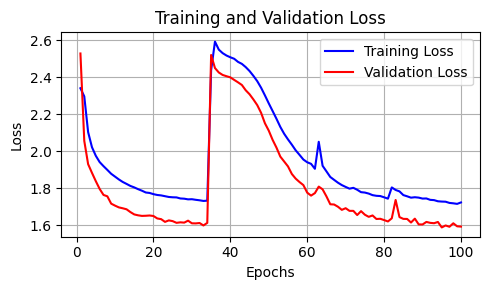

In [ ]:
# draw loss graph

plot_loss(history)

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/03-NLP/assignment/PROBLEM2/p2_model7_2.keras')

Comment: Not very good.

### Model 6-3

Data cleaning now exclude capital letters



In [ ]:
# build and compile model

model = Sequential()
model.add(keras.Input(shape=(maxlen, len(chars))))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(chars), activation='softmax'))

print(model.summary())

optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 100, 64)        │        32,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 61)             │         3,965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,245 (270.49 KB)

 Trainable params: 69,245 (270.49 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# model training

history = train_model_with_tracking(
    model=model,
    x=x,
    y=y,
    text=text,
    maxlen=maxlen,
    chars=chars,
    char_indices=char_indices,
    epochs=100,
    generate_func=generate_text_during_training,  # Optional
    log_file="generated_text_log.txt")


 Epoch 1/100
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - loss: 2.4745 - val_loss: 1.7745

=== Epoch 1 | Seed: "peoples favorite class. Only Draco Malfoy and his gang of Slytherins had anything bad to say about P" ===


-- Temperature 0.2 --
peoples favorite class. Only Draco Malfoy and his gang of Slytherins had anything bad to say about Professor Hermione stow the stould and the dind and the stare to he was the here a look his beale and said Harry had the sented the was the was the deak of the stered the strook of the had said Harry was the stere the stere the the the stere the could the stere the mint of the was the stould the meath of the pare the was the thould of the was the was was the strook of the was the was the stand and 


-- Temperature 0.5 --
peoples favorite class. Only Draco Malfoy and his gang of Slytherins had anything bad to say about Poreed por a reing the halt was be out the and bot his there take he sted, he that Harry that falle could of the could to Should to

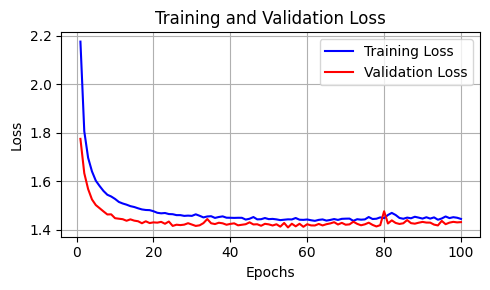

In [ ]:
# plot loss graph

plot_loss(history)

In [ ]:
# save the model

model.save('/content/drive/MyDrive/Colab Notebooks/03-NLP/assignment/PROBLEM2/p2_model6_3.keras')

In [ ]:
# seed

import random

start_index = random.randint(0, len(text) - maxlen - 1) #randomly grab a piece of text from the original document
seed_text = text[start_index: start_index + maxlen] # what is used to input to the model for continuation

print("Seed text:\n", seed_text)

# generate text

generated_text = generate_text(
    model=model,
    seed_text=seed_text,
    length=400,
    chars=chars,
    char_indices=char_indices,
    maxlen=maxlen,
    temperature=0.5  # Adjust for creativity: lower = conservative, higher = creative
)

print("Generated text:\n", generated_text)

Seed text:
 . He gave it to all of us. Did he, now? said Madam Pomfrey approvingly. So weve finally got a Defens
Generated text:
 . He gave it to all of us. Did he, now? said Madam Pomfrey approvingly. So weve finally got a Defense of the top of the castle from the stay to the feel had to make the table and a castle as though for a strelinhers post but the windor, said Harry. The castle whispered the stand reached the stairs and stood and the the broker and caused to the hard and find on him and of the entrance back to still be looked at the boy of the feel something excell watching Magic who could still be to a hand and h


In [ ]:
# evaluate generated text

evaluate_generated_text(generated_text)

{'diversity': {'total_chars': 500,
  'unique_char_count': 27,
  'unique_word_count': 63,
  'unique_word_ratio': 0.6176470588235294,
  'repetition_count': 1,
  'repetition_rate': 0.00980392156862745},
 'accuracy': {'total_words': 102,
  'known_english_words': 94,
  'unknown_words': 8,
  'accuracy_ratio': 0.9215686274509803}}

just 50 epochs

In [ ]:
# model training

history = train_model_with_tracking(
    model=model,
    x=x,
    y=y,
    text=text,
    maxlen=maxlen,
    chars=chars,
    char_indices=char_indices,
    epochs=50,
    generate_func=generate_text_during_training,  # Optional
    log_file="generated_text_log.txt")


 Epoch 1/50
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - loss: 2.5011 - val_loss: 1.7942

=== Epoch 1 | Seed: ", closed the desk drawers, and turned to look at Harry. Here I brought this from the Shrieking Shack" ===


-- Temperature 0.2 --
, closed the desk drawers, and turned to look at Harry. Here I brought this from the Shrieking Shack the mant the strest the start the said the start the stare the start the sare the stare the to start the start the tint the stoll the start the start the wast the sale the start the stant the said and Harry the start the said the sint one the start the said the tart the said on the start the tint the said the start his the start the wart the said the said on the start the stare the said the stare


-- Temperature 0.5 --
, closed the desk drawers, and turned to look at Harry. Here I brought this from the Shrieking Shack the dit a mint. Harry was seet the mortion stare strong the tint againto they thing the retore him rears and Harry shenty. The you

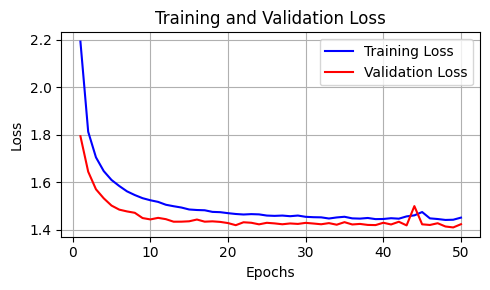

In [ ]:
# plot loss graph

plot_loss(history)

In [ ]:
# save the model

model.save('/content/drive/MyDrive/Colab Notebooks/03-NLP/assignment/PROBLEM2/p2_model6_3_50ep.keras')

In [ ]:
# seed

import random

start_index = random.randint(0, len(text) - maxlen - 1) #randomly grab a piece of text from the original document
seed_text = text[start_index: start_index + maxlen] # what is used to input to the model for continuation

print("Seed text:\n", seed_text)

# generate text

generated_text = generate_text(
    model=model,
    seed_text=seed_text,
    length=400,
    chars=chars,
    char_indices=char_indices,
    maxlen=maxlen,
    temperature=0.5  # Adjust for creativity: lower = conservative, higher = creative
)

print("Generated text:\n", generated_text)

Seed text:
 cks hands if you went looking for him. Your mum and dad wouldnt want you to get hurt, would they? Th
Generated text:
 cks hands if you went looking for him. Your mum and dad wouldnt want you to get hurt, would they? The suning to be treaked the botter in his bestigus of the stridger of the stairs of the worsing about like a long, showly and down and said that something on all of the take the stopped and said, Harry inside a best and there off of the shorted the call had to the train of the suddenly and was a patch his and room the first, he knew that must, said Hermione and he was shelve good to stay, she looke


In [ ]:
# evaluate generated text

evaluate_generated_text(generated_text)

{'diversity': {'total_chars': 500,
  'unique_char_count': 26,
  'unique_word_count': 67,
  'unique_word_ratio': 0.6568627450980392,
  'repetition_count': 0,
  'repetition_rate': 0.0},
 'accuracy': {'total_words': 102,
  'known_english_words': 90,
  'unknown_words': 12,
  'accuracy_ratio': 0.8823529411764706}}

40 epochs

In [ ]:
# model training

history = train_model_with_tracking(
    model=model,
    x=x,
    y=y,
    text=text,
    maxlen=maxlen,
    chars=chars,
    char_indices=char_indices,
    epochs=40,
    generate_func=generate_text_during_training,  # Optional
    log_file="generated_text_log.txt")


 Epoch 1/40
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 2.5240 - val_loss: 1.8101

=== Epoch 1 | Seed: "p too. I am no longer your teacher, so I dont feel guilty about giving you back this as well. Its no" ===


-- Temperature 0.2 --
p too. I am no longer your teacher, so I dont feel guilty about giving you back this as well. Its now and the said Harry said Harry said Harry was said Harry and said Harry said Harry and and the said Harry and the said Harry the said Harry said The said Harry and the cant the said Harry said Harry said Harry said Harry said Harry said Harry said Harry said I said Harry said Harry and the said Harry and the said Harry had the said Harry said Harry said Harry and the said Harry of the said Harry 


-- Temperature 0.5 --
p too. I am no longer your teacher, so I dont feel guilty about giving you back this as well. Its now have and was said Harry fart and in the was lead the Tresping and down ot of the cats the bill and was he to the had botter well 

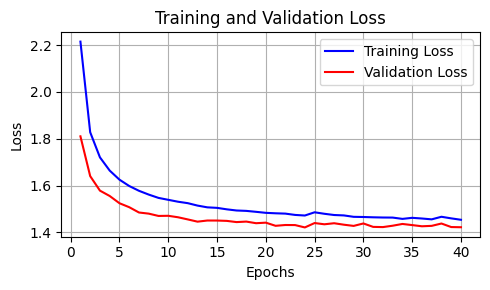

In [ ]:
# plot loss graph

plot_loss(history)

In [ ]:
# save the model

model.save('/content/drive/MyDrive/Colab Notebooks/03-NLP/assignment/PROBLEM2/p2_model6_3_40ep.keras')

In [ ]:
# seed

import random

start_index = random.randint(0, len(text) - maxlen - 1) #randomly grab a piece of text from the original document
seed_text = text[start_index: start_index + maxlen] # what is used to input to the model for continuation

print("Seed text:\n", seed_text)

# generate text

generated_text = generate_text(
    model=model,
    seed_text=seed_text,
    length=400,
    chars=chars,
    char_indices=char_indices,
    maxlen=maxlen,
    temperature=0.5  # Adjust for creativity: lower = conservative, higher = creative
)

print("Generated text:\n", generated_text)

Seed text:
 a dog. Ive been living in the forest ever since, except when I came to watch the Quidditch, of cours
Generated text:
 a dog. Ive been living in the forest ever since, except when I came to watch the Quidditch, of course he said of the train looking of book. He she was the class was something as the when he said the in the only a brite to face with Alley scramear to the starte of the boytorys face happened as that and Marce of the tont then said to see he was a few and the tont to exatter the end of the end of the shape was a horre to her search to him of a said on her hand someone carefully followed so mouth at


In [ ]:
# evaluate generated text

evaluate_generated_text(generated_text)

{'diversity': {'total_chars': 500,
  'unique_char_count': 27,
  'unique_word_count': 60,
  'unique_word_ratio': 0.5607476635514018,
  'repetition_count': 0,
  'repetition_rate': 0.0},
 'accuracy': {'total_words': 107,
  'known_english_words': 94,
  'unknown_words': 13,
  'accuracy_ratio': 0.8785046728971962}}

### Model 6-4

- maxlen to 160

In [ ]:
# build and compile model

model = Sequential()
model.add(keras.Input(shape=(maxlen, len(chars))))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(chars), activation='softmax'))

print(model.summary())

optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 160, 64)        │        32,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 61)             │         3,965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,245 (270.49 KB)

 Trainable params: 69,245 (270.49 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# model training

history = train_model_with_tracking(
    model=model,
    x=x,
    y=y,
    text=text,
    maxlen=maxlen,
    chars=chars,
    char_indices=char_indices,
    epochs=100,
    generate_func=generate_text_during_training,  # Optional
    log_file="generated_text_log.txt")


 Epoch 1/100
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 2.4875 - val_loss: 1.7529

=== Epoch 1 | Seed: "en to see me. Were playing Hufflepuff instead. Why? chorused the rest of the team. Flints excuse is that their Seekers arms still injured, said Wood, grinding h" ===


-- Temperature 0.2 --
en to see me. Were playing Hufflepuff instead. Why? chorused the rest of the team. Flints excuse is that their Seekers arms still injured, said Wood, grinding har the said and the said the said the said the the said the said har to the said the said the said the said the said the was the was the said the was the the were some of the said the pared and the was the was to the to the come the said the was to the was the said Harry was the said the said the was the was have to the was the was said the for the said the said the said the was the was the said H


-- Temperature 0.5 --
en to see me. Were playing Hufflepuff instead. Why? chorused the rest of the team. Flints excuse is that their

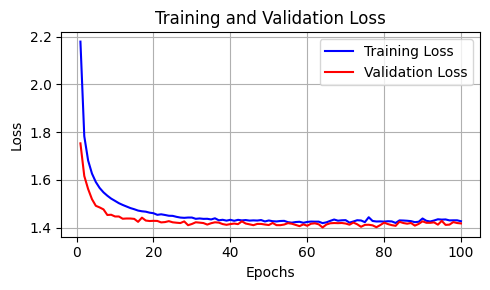

In [ ]:
# plot loss graph

plot_loss(history)

In [ ]:
# save the model

model.save('/content/drive/MyDrive/Colab Notebooks/03-NLP/assignment/PROBLEM2/p2_model6_4.keras')

max len increase, increases the chance that overfitting will happen earlier...

In [ ]:
# seed

import random

start_index = random.randint(0, len(text) - maxlen - 1) #randomly grab a piece of text from the original document
seed_text = text[start_index: start_index + maxlen] # what is used to input to the model for continuation

print("Seed text:\n", seed_text)

# generate text

generated_text = generate_text(
    model=model,
    seed_text=seed_text,
    length=400,
    chars=chars,
    char_indices=char_indices,
    maxlen=maxlen,
    temperature=0.5  # Adjust for creativity: lower = conservative, higher = creative
)

print("Generated text:\n", generated_text)

Seed text:
 hen something caught his eye. An animal of some kind was prowling across the silvery lawn. Harry dashed to his bedside table, snatched up his glasses, and put t
Generated text:
 hen something caught his eye. An animal of some kind was prowling across the silvery lawn. Harry dashed to his bedside table, snatched up his glasses, and put the shouldily their top of the face was started to the managed the stronger. I you they were a lettered him from the teacher and the entrance of him. I leaves to be given his hand in the possed to me the hand as though it prosted the tanking nearly of leave at the exast he still stringed it in the thick to the barthed a first malled the statue like it to the back of the mouth without the staircos a


In [ ]:
# evaluate generated text

evaluate_generated_text(generated_text)

{'diversity': {'total_chars': 560,
  'unique_char_count': 26,
  'unique_word_count': 72,
  'unique_word_ratio': 0.6545454545454545,
  'repetition_count': 0,
  'repetition_rate': 0.0},
 'accuracy': {'total_words': 110,
  'known_english_words': 99,
  'unknown_words': 11,
  'accuracy_ratio': 0.9}}

train for 50 epochs


In [ ]:
# build and compile model

model = Sequential()
model.add(keras.Input(shape=(maxlen, len(chars))))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(chars), activation='softmax'))

print(model.summary())

optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 160, 64)        │        32,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 61)             │         3,965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,245 (270.49 KB)

 Trainable params: 69,245 (270.49 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# model training

history = train_model_with_tracking(
    model=model,
    x=x,
    y=y,
    text=text,
    maxlen=maxlen,
    chars=chars,
    char_indices=char_indices,
    epochs=50,
    generate_func=generate_text_during_training,  # Optional
    log_file="generated_text_log.txt")


 Epoch 1/50
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - loss: 2.4549 - val_loss: 1.7125

=== Epoch 1 | Seed: "to make, said Dumbledore softly. I expect you tire of hearing it, but you do look extraordinarily like James. Except for the eyes ... you have your mothers eyes" ===


-- Temperature 0.2 --
to make, said Dumbledore softly. I expect you tire of hearing it, but you do look extraordinarily like James. Except for the eyes ... you have your mothers eyes the sto a the sto the are was the the sto the tarted was the the sto the sto the sto the sto the stared the the ster the the the the the stains and sto the the and the sto the cant the sto the the the sto the could the the the stered and the the said on the are and ster and the the and sto the the the the still had to the sto the sto the the sto the and the the the the sto the painst and the the 


-- Temperature 0.5 --
to make, said Dumbledore softly. I expect you tire of hearing it, but you do look extraordinarily like James. E

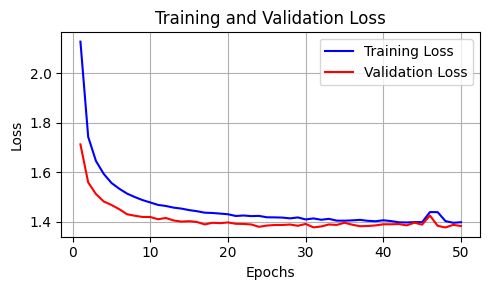

In [ ]:
# plot loss graph

plot_loss(history)

In [ ]:
# save the model

model.save('/content/drive/MyDrive/Colab Notebooks/03-NLP/assignment/PROBLEM2/p2_model6_4b_50ep.keras')

In [ ]:
# seed

import random

start_index = random.randint(0, len(text) - maxlen - 1) #randomly grab a piece of text from the original document
seed_text = text[start_index: start_index + maxlen] # what is used to input to the model for continuation

print("Seed text:\n", seed_text)

# generate text

generated_text = generate_text(
    model=model,
    seed_text=seed_text,
    length=400,
    chars=chars,
    char_indices=char_indices,
    maxlen=maxlen,
    temperature=0.5  # Adjust for creativity: lower = conservative, higher = creative
)

print("Generated text:\n", generated_text)

Seed text:
  normal schedule again. I still cant believe you didnt tell us about it, said Ron grumpily. Were supposed to be your friends. I promised I wouldnt tell anyone, 
Generated text:
  normal schedule again. I still cant believe you didnt tell us about it, said Ron grumpily. Were supposed to be your friends. I promised I wouldnt tell anyone, he stopped to a think, the feaks nervously and straighter of the happed for his book to the lake with the headmole on the soont to could benet again. Harry was in a the clust for and and a drive me on the team bebe looked adred to sharing his beard where you do a that maning something want the crowding into the end of the end of the trang the eventor of him, which beneel the hanger. If he sick and


In [ ]:
# evaluate generated text

evaluate_generated_text(generated_text)

{'diversity': {'total_chars': 560,
  'unique_char_count': 25,
  'unique_word_count': 75,
  'unique_word_ratio': 0.6818181818181818,
  'repetition_count': 1,
  'repetition_rate': 0.00909090909090909},
 'accuracy': {'total_words': 110,
  'known_english_words': 93,
  'unknown_words': 17,
  'accuracy_ratio': 0.8454545454545455}}

### Model 6-5

In [ ]:
# build and compile model

model = Sequential()
model.add(keras.Input(shape=(maxlen, len(chars))))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.1))
model.add(layers.LSTM(64))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(chars), activation='softmax'))

print(model.summary())

optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 160, 64)        │        32,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 160, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 160, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 61)             │         3,965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,269 (399.49 KB)

 Trainable params: 102,269 (399.49 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# model training

history = train_model_with_tracking(
    model=model,
    x=x,
    y=y,
    text=text,
    maxlen=maxlen,
    chars=chars,
    char_indices=char_indices,
    epochs=40,
    generate_func=generate_text_during_training,  # Optional
    log_file="generated_text_log.txt")


 Epoch 1/40
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - loss: 2.9262 - val_loss: 2.1325

=== Epoch 1 | Seed: " Fat Lady. Sir Cadogan was the only one brave enough to volunteer. Sir Cadogan, however, was the least of Harrys worries. He was now being closely watched. Teac" ===


-- Temperature 0.2 --
 Fat Lady. Sir Cadogan was the only one brave enough to volunteer. Sir Cadogan, however, was the least of Harrys worries. He was now being closely watched. Teace the con has the was the said the the said had the the the the the the the the has the the wad the cat the we was the the bat his a the was the said was the was to the the was be a las was was the was the was to the the had the the the wis the the the the has the said the the the the said the bat the sale the the the the was has the cat the los to the the the the the ceare the the pat the wis the


-- Temperature 0.5 --
 Fat Lady. Sir Cadogan was the only one brave enough to volunteer. Sir Cadogan, however, was the least of Harry

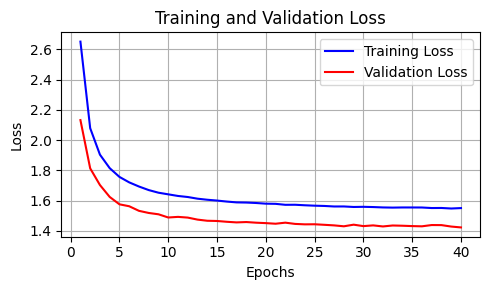

In [ ]:
# generate loss graph

plot_loss(history)

In [ ]:
# save the model

model.save('/content/drive/MyDrive/Colab Notebooks/03-NLP/assignment/PROBLEM2/p2_model6_5.keras')


In [ ]:
# seed

import random

start_index = random.randint(0, len(text) - maxlen - 1) #randomly grab a piece of text from the original document
seed_text = text[start_index: start_index + maxlen] # what is used to input to the model for continuation

print("Seed text:\n", seed_text)

# generate text

generated_text = generate_text(
    model=model,
    seed_text=seed_text,
    length=400,
    chars=chars,
    char_indices=char_indices,
    maxlen=maxlen,
    temperature=0.5  # Adjust for creativity: lower = conservative, higher = creative
)

print("Generated text:\n", generated_text)



Seed text:
  scampered. Why, though? Ron added to Harry as the group of secondyear girls who had been listening to his chilling tale departed. Why did he run? Harry had bee
Generated text:
  scampered. Why, though? Ron added to Harry as the group of secondyear girls who had been listening to his chilling tale departed. Why did he run? Harry had been he was the room and the stams all been shoulder of the the hippogriff and the bame had for the this come and he was make the partairly the far seemed to go enticing to the lass of the long to the stast that the never and appeared a foursed bit of the noise. The both to super out of the fealed him a broomstered at the hand that at his floors to his stand and Harry castle and to the class silled t


In [ ]:
# evaluate generated text

evaluate_generated_text(generated_text)

{'diversity': {'total_chars': 560,
  'unique_char_count': 26,
  'unique_word_count': 65,
  'unique_word_ratio': 0.5752212389380531,
  'repetition_count': 1,
  'repetition_rate': 0.008849557522123894},
 'accuracy': {'total_words': 113,
  'known_english_words': 99,
  'unknown_words': 14,
  'accuracy_ratio': 0.8761061946902655}}

### Model 6-6

In [ ]:
# build and compile model

model = Sequential()
model.add(keras.Input(shape=(maxlen, len(chars))))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(chars), activation='softmax'))

print(model.summary())

optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 160, 64)        │        32,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 160, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 61)             │         3,965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,269 (399.49 KB)

 Trainable params: 102,269 (399.49 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# model training

history = train_model_with_tracking(
    model=model,
    x=x,
    y=y,
    text=text,
    maxlen=maxlen,
    chars=chars,
    char_indices=char_indices,
    epochs=30,
    generate_func=generate_text_during_training,  # Optional
    log_file="generated_text_log.txt")


 Epoch 1/30
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 2.6505 - val_loss: 1.9335

=== Epoch 1 | Seed: "m. He hadnt told anyone about the Grim, not even Ron and Hermione, because he knew Ron would panic and Hermione would scoff. The fact remained, however, that it" ===


-- Temperature 0.2 --
m. He hadnt told anyone about the Grim, not even Ron and Hermione, because he knew Ron would panic and Hermione would scoff. The fact remained, however, that it the the couk the the the said Harry the and the he was he and the said Harry the was the had the dow and the and his the chow said Harry the was the said Harry the could the the dook the was the was the said Harry the couk his he the said Harry the was the stare the the couk the said Harry the couk his the the the coud the said Harry the the che the said Harry the the the his the the the stare th


-- Temperature 0.5 --
m. He hadnt told anyone about the Grim, not even Ron and Hermione, because he knew Ron would panic and Hermione

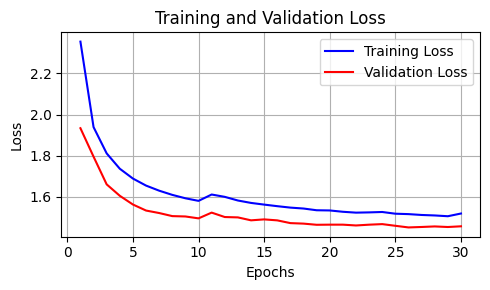

In [ ]:
# generate loss graph

plot_loss(history)

In [ ]:
# save the model

model.save('/content/drive/MyDrive/Colab Notebooks/03-NLP/assignment/PROBLEM2/p2_model6_6.keras')

In [ ]:
# generate text based on random seed

import random

start_index = random.randint(0, len(text) - maxlen - 1) #randomly grab a piece of text from the original document
seed_text = text[start_index: start_index + maxlen] # what is used to input to the model for continuation

print("Seed text:\n", seed_text)

# generate text

generated_text = generate_text(
    model=model,
    seed_text=seed_text,
    length=400,
    chars=chars,
    char_indices=char_indices,
    maxlen=maxlen,
    temperature=0.5  # Adjust for creativity: lower = conservative, higher = creative
)

print("Generated text:\n", generated_text)

Seed text:
 en there were cats of every color, a noisy cage of ravens, a basket of funny custardcolored furballs that were humming loudly, and on the counter, a vast cage o
Generated text:
 en there were cats of every color, a noisy cage of ravens, a basket of funny custardcolored furballs that were humming loudly, and on the counter, a vast cage of the common room was could that the taight up the fieted come and the face had a looked his fain and back him the hage the room of his cherent were for feet brange to a plass and should the hogoped the soul to the Black the Firebolt with a passed the top and he took up of the heard the crowd as there was said to a wand of the something the brack and said but the formed teether of his wand what he


In [ ]:
# evaluate generated text

evaluate_generated_text(generated_text)

{'diversity': {'total_chars': 560,
  'unique_char_count': 24,
  'unique_word_count': 66,
  'unique_word_ratio': 0.5739130434782609,
  'repetition_count': 0,
  'repetition_rate': 0.0},
 'accuracy': {'total_words': 115,
  'known_english_words': 101,
  'unknown_words': 14,
  'accuracy_ratio': 0.8782608695652174}}

### Model 7

GRU layers

Note: It seems that one cannot use layers interchangeably. If using GRU, one must rethink the structure from scratch.

In [ ]:
# build and compile model

model = Sequential()
model.add(keras.Input(shape=(maxlen, len(chars))))
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.GRU(64))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(chars), activation='softmax'))

print(model.summary())

optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 160, 64)        │        24,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 61)             │         3,965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,309 (208.24 KB)

 Trainable params: 53,309 (208.24 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# model training

history = train_model_with_tracking(
    model=model,
    x=x,
    y=y,
    text=text,
    maxlen=maxlen,
    chars=chars,
    char_indices=char_indices,
    epochs=50,
    generate_func=generate_text_during_training,  # Optional
    log_file="generated_text_log.txt")


 Epoch 1/50
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - loss: 2.2663 - val_loss: 1.7237

=== Epoch 1 | Seed: "lf flat on his bed, thrown backward by the speed of the Knight Bus. Pulling himself up, Harry stared out of the dark window and saw that they were now bowling a" ===


-- Temperature 0.2 --
lf flat on his bed, thrown backward by the speed of the Knight Bus. Pulling himself up, Harry stared out of the dark window and saw that they were now bowling and and the the said and the said and the said and the would to the could a book and of the said and he had be to he had be to he head and and and he said and the would to the look and the would let and lessing to her were he had be the said and the said and be to he had be to the said and was a said and the rating and the like and he his been and and he said and left and said said and the said Ron


-- Temperature 0.5 --
lf flat on his bed, thrown backward by the speed of the Knight Bus. Pulling himself up, Harry stared out of the

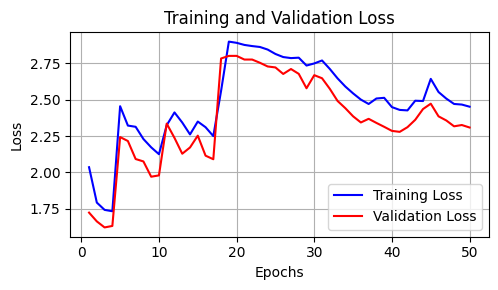

In [ ]:
# plot loss graph

plot_loss(history)

In [ ]:
# save the model

model.save('/content/drive/MyDrive/Colab Notebooks/03-NLP/assignment/PROBLEM2/p2_model8.keras')

In [ ]:
# seed

import random

start_index = random.randint(0, len(text) - maxlen - 1) #randomly grab a piece of text from the original document
seed_text = text[start_index: start_index + maxlen] # what is used to input to the model for continuation

print("Seed text:\n", seed_text)

# generate text

generated_text = generate_text(
    model=model,
    seed_text=seed_text,
    length=400,
    chars=chars,
    char_indices=char_indices,
    maxlen=maxlen,
    temperature=0.5  # Adjust for creativity: lower = conservative, higher = creative
)

print("Generated text:\n", generated_text)

In [ ]:
# evaluate generated text

evaluate_generated_text(generated_text)

## Step 3 – Use the developed Model to generate the characters / sentences

### **Note: Assignment_Problem2_Testing.ipynb was used to test the final models.**

### Functions for evaluation

- data generation
- perplexity score (not done in the end. Perplexity scoring is more likely for word generation) In any case, it seems to take a long time and the cloud crashed out due to lack of RAM.

In [ ]:


import tensorflow as tf
import numpy as np

def data_generator(data, chars, char_indices, maxlen, batch_size):
    """
    Generator that yields batches of sequences and targets for perplexity calculation.
    """
    i = 0
    while True:
        x_batch = np.zeros((batch_size, maxlen, len(chars)), dtype=bool)
        y_batch = np.zeros((batch_size, len(chars)), dtype=np.bool_)
        for b in range(batch_size):
            if (i + maxlen) >= len(data):
                # Reset generator if we reach the end of the data
                i = 0
            sentence = data[i: i + maxlen]
            for t, char in enumerate(sentence):
                if char in char_indices:
                    x_batch[b, t, char_indices[char]] = 1
            if (i + maxlen) < len(data) and data[i + maxlen] in char_indices:
                y_batch[b, char_indices[data[i + maxlen]]] = 1
            i += 1
        yield x_batch, y_batch


def calculate_perplexity(model, data, chars, char_indices, maxlen, batch_size=128):
    """
    Calculates the perplexity of the model on the given data using a generator.

    Parameters:
        model: Trained Keras model.
        data: The text data (string) to evaluate on.
        chars: List of unique characters in the vocabulary.
        char_indices: Dictionary mapping characters to their indices.
        maxlen: The length of the input sequences the model expects.
        batch_size: The batch size for processing data.

    Returns:
        The perplexity score.
    """
    steps_per_epoch = (len(data) - maxlen) // 1

    # Use the generator to get data in batches
    generator = data_generator(data, chars, char_indices, maxlen, batch_size)

    # Predict probabilities for the next character using the generator
    predictions = model.predict(generator, steps=steps_per_epoch, verbose=0)

    # Create the corresponding true targets
    y_true = np.zeros((steps_per_epoch * batch_size, len(chars)), dtype=np.bool_)
    i = 0
    for _ in range(steps_per_epoch):
        for b in range(batch_size):
             if (i + maxlen) < len(data) and data[i + maxlen] in char_indices:
                y_true[(_*steps_per_epoch)+b, char_indices[data[i + maxlen]]] = 1
             i += 1

    # Flatten the predictions and y_true to match the shape of the predictions from predict
    predictions_flat = predictions.reshape(-1, len(chars))
    y_true_flat = y_true[:predictions_flat.shape[0]] # Ensure shapes match

    # Calculate cross-entropy loss
    # We need to clip predictions to avoid log(0)
    epsilon = 1e-10
    predictions_flat = np.clip(predictions_flat, epsilon, 1. - epsilon)

    # Calculate the sum of cross-entropy for the relevant predictions
    relevant_predictions = predictions_flat[np.sum(y_true_flat, axis=1) > 0]
    relevant_y_true = y_true_flat[np.sum(y_true_flat, axis=1) > 0]

    if relevant_y_true.shape[0] == 0:
        return float('inf') # Avoid division by zero if no valid targets

    cross_entropy = -np.sum(relevant_y_true * np.log(relevant_predictions)) / relevant_y_true.shape[0]

    # Perplexity is 2 raised to the power of the cross-entropy
    perplexity = 2 ** cross_entropy

    return perplexity

# Example usage:
# Assuming 'model', 'text', 'chars', 'char_indices', and 'maxlen' are already defined from your notebook
# perplexity_score = calculate_perplexity(model, text, chars, char_indices, maxlen)
# print(f"Perplexity: {perplexity_score}")

### Evaluation of model 6-4

In [ ]:
# load the model

model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/03-NLP/assignment/PROBLEM2/p2_model6_4.keras')

In [ ]:
# takes the user input, print the number of characters submitted
text_input = input("Please enter a seed sentence: ")
print("Number of characters: ", len(text_input))



# pad text input up to maxlen or truncate the input to fit maxlen

# Check if text_input is shorter than maxlen and pad if necessary

if len(text_input) < maxlen:
    padded_text_input = text_input.rjust(maxlen, ' ') # Pad with spaces
    print("Padded text input:", padded_text_input)
elif len(text_input) > maxlen:
    padded_text_input = text_input[:maxlen] # Truncate if longer
    print("Truncated text input:", padded_text_input)
else:
    padded_text_input = text_input
    print("Text input:", padded_text_input)




Please enter a seed sentence: This separation from his spellbooks had been a real  problem for Harry, because his teachers at Hogwarts  had given him a lot of holiday work. One of the  essays, a particularly nasty one about shrinking  potions, was 
Number of characters:  218
Truncated text input: This separation from his spellbooks had been a real  problem for Harry, because his teachers at Hogwarts  had given him a lot of holiday work. One of the  essay


In [ ]:
# encode the user input

x_pred = np.zeros((1, maxlen, len(chars)), dtype=bool)
for t, char in enumerate(padded_text_input):
    if char in char_indices:
        x_pred[0, t, char_indices[char]] = 1.0
    else:
        # Handle characters not in the training set, e.g., by ignoring them or using a placeholder
        print(f"Warning: Character '{char}' not found in vocabulary. Skipping.")

print("Shape of encoded input:", x_pred.shape)

Shape of encoded input: (1, 160, 61)


In [ ]:
# Use the Best Model to generate 400 characters
generated_text = generate_text(
    model=model,
    seed_text=padded_text_input,
    length=400,
    chars=chars,
    char_indices=char_indices,
    maxlen=maxlen,
    temperature=0.7  # You can adjust the temperature here
)

print("Generated text:\n", generated_text)

Generated text:
 He watched a group of students in flowing black robes chatter excitedly as a majestic barn owl, a newly purchased pet, hooted softly from its cage. The street with the teach to killed and of him telling making their new stared of what they were stopped be to be out the hiddesser hair that shouthting for her not, said Lupin really. The long a heading it you are no defenped the map were one honey to undertaid team didnt be a map from not tried anything pocket into the chot to leave the dementors permiss, he had think before to like out to a roll. There wer


In [ ]:
temps = [0.1, 0.3, 0.5, 0.7, 0.9]

for temp in temps:

  generated_text = generate_text(
    model=model,
    seed_text=padded_text_input,
    length=400,
    chars=chars,
    char_indices=char_indices,
    maxlen=maxlen,
    temperature=temp  # You can adjust the temperature here
  )

  evaluation_results = evaluate_generated_text(generated_text)

  print("Generated text:\n", generated_text)
  print("Temperature: ", temp)
  print("Evaluation Results:", evaluation_results)
  print("\n")




Generated text:
 This separation from his spellbooks had been a real  problem for Harry, because his teachers at Hogwarts  had given him a lot of holiday work. One of the  essay the staircase of the staircase and start of the staircase of the stairs to the staircase of the stairs to the first the staircance to the staircase and the stairs to the train to the stepse to the staircase to the face was started to the stairs to the staircase of the stairs to the staircase of the staircase to the staircase of the stateres the time to the train the staircase of the staircase of 
Temperature:  0.1
Evaluation Results: {'diversity': {'total_chars': 560, 'unique_char_count': 25, 'unique_word_count': 39, 'unique_word_ratio': 0.37142857142857144, 'repetition_count': 0, 'repetition_rate': 0.0}, 'accuracy': {'total_words': 105, 'known_english_words': 93, 'unknown_words': 12, 'accuracy_ratio': 0.8857142857142857}}


Generated text:
 This separation from his spellbooks had been a real  problem for Harry

### Evaluation of model 6-6

In [ ]:
# load the model

model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/03-NLP/assignment/PROBLEM2/p2_model6_6.keras')

In [ ]:
# takes the user input, print the number of characters submitted
text_input = input("Please enter a seed sentence: ")
print("Number of characters: ", len(text_input))



# pad text input up to maxlen or truncate the input to fit maxlen

# Check if text_input is shorter than maxlen and pad if necessary

if len(text_input) < maxlen:
    padded_text_input = text_input.rjust(maxlen, ' ') # Pad with spaces
    print("Padded text input:", padded_text_input)
elif len(text_input) > maxlen:
    padded_text_input = text_input[:maxlen] # Truncate if longer
    print("Truncated text input:", padded_text_input)
else:
    padded_text_input = text_input
    print("Text input:", padded_text_input)



Please enter a seed sentence: This separation from his spellbooks had been a real  problem for Harry, because his teachers at Hogwarts  had given him a lot of holiday work. One of the  essay
Number of characters:  160
Text input: This separation from his spellbooks had been a real  problem for Harry, because his teachers at Hogwarts  had given him a lot of holiday work. One of the  essay


In [ ]:
# encode the user input

x_pred = np.zeros((1, maxlen, len(chars)), dtype=bool)
for t, char in enumerate(padded_text_input):
    if char in char_indices:
        x_pred[0, t, char_indices[char]] = 1.0
    else:
        # Handle characters not in the training set, e.g., by ignoring them or using a placeholder
        print(f"Warning: Character '{char}' not found in vocabulary. Skipping.")

print("Shape of encoded input:", x_pred.shape)

Shape of encoded input: (1, 160, 61)


In [ ]:
# Use the loaded model to generate 400 characters
generated_text = generate_text(
    model=model,
    seed_text=padded_text_input,
    length=400,
    chars=chars,
    char_indices=char_indices,
    maxlen=maxlen,
    temperature=0.7  # You can adjust the temperature here
)

print("Generated text:\n", generated_text)

Generated text:
 This separation from his spellbooks had been a real  problem for Harry, because his teachers at Hogwarts  had given him a lot of holiday work. One of the  essay, there looked at the hagily the fieting and door and to it. The school. He looked his heading the presentioncing about her . . . . stoping the end in his along not to Harry. It ask lefh Harry stopped and that am last a long and a kass away witging still of eat in there quieting, how the Snitch of there off and from Hogsmeade about feet to and and had gave it do student and before Harry cheal to h


In [ ]:
# Use the loaded model to generate 400 characters with various temperature settings

temps = [0.1, 0.3, 0.5, 0.7, 0.9]

for temp in temps:

  generated_text = generate_text(
    model=model,
    seed_text=padded_text_input,
    length=400,
    chars=chars,
    char_indices=char_indices,
    maxlen=maxlen,
    temperature=temp
  )

  evaluation_results = evaluate_generated_text(generated_text)

  print("Generated text:\n", generated_text)
  print("Temperature: ", temp)
  print("Evaluation Results:", evaluation_results)
  print("\n")


Generated text:
 This separation from his spellbooks had been a real  problem for Harry, because his teachers at Hogwarts  had given him a lot of holiday work. One of the  essay and the sound to the someth a stopped to the somether and the sat the start to the someth the silend and the someth his tonight to the sat the ward and the sound of the said the ward to the said to the sat and the start and the saw to the said the said to the someth his for the sat the start to the said the saw the tare and the said to the start and the said and had to the hange to the start and 
Temperature:  0.1
Evaluation Results: {'diversity': {'total_chars': 560, 'unique_char_count': 25, 'unique_word_count': 40, 'unique_word_ratio': 0.33613445378151263, 'repetition_count': 0, 'repetition_rate': 0.0}, 'accuracy': {'total_words': 119, 'known_english_words': 110, 'unknown_words': 9, 'accuracy_ratio': 0.9243697478991597}}


Generated text:
 This separation from his spellbooks had been a real  problem for Harry